## Mnist reconstruction using ddqn and spirit
*Let's find out...*

In [4]:
import time
import gym
import math
import random
import numpy as np
import os   
import matplotlib.pyplot as plt
import abc
from sklearn.preprocessing import MinMaxScaler
from collections import namedtuple, deque 
from easydict import EasyDict as edict 
from typing import (Any, Callable, Dict, Iterator, List, Mapping, Optional, Sequence, Sized, Tuple, Union)
from reconstructor import supervised_model

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset 
from torch.autograd import Variable


Number of acquired points in the whole mask : 7
Number of acquired points in the local mask of size [28, 28] : 7
acceleration : 0.25


In [5]:
pip install complexPyTorch

In [7]:
from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

## Data settings

In [8]:
##load data
mnist_train = torchvision.datasets.MNIST(root='../', train=True, download=True,) #'./'
                             #transform=t)

X_mnist_train, y_mnist_train = (mnist_train.data)/255., (mnist_train.targets)
X_mnist_train = X_mnist_train.reshape((len(mnist_train),1,28,28))

mnist_test = torchvision.datasets.MNIST(root= '../',train=False, download=True,)
                             #transform=t)

X_mnist_test, y_mnist_test = (mnist_test.data)/255., (mnist_test.targets)
X_mnist_test =X_mnist_test.reshape((len(mnist_test),1,28,28))


Extracting ../MNIST\raw\train-images-idx3-ubyte.gz to ../MNIST\raw




Extracting ../MNIST\raw\train-labels-idx1-ubyte.gz to ../MNIST\raw




Extracting ../MNIST\raw\t10k-images-idx3-ubyte.gz to ../MNIST\raw




Extracting ../MNIST\raw\t10k-labels-idx1-ubyte.gz to ../MNIST\raw



In [9]:
from numpy.fft import fftshift, ifftshift, fftn, ifftn
def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img
  
def transform_image_to_kspace(img, dim=None, k_shape=None):
  """ Computes the Fourier transform from image space to k-space space
  along a given or all dimensions
  :param img: image space data
  :param dim: vector of dimensions to transform
  :param k_shape: desired shape of output k-space data
  :returns: data in k-space (along transformed dimensions)
  """
  if not dim:
      dim = range(img.ndim)

  k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim) # fftshi()
  #k /= np.sqrt(np.prod(np.take(img.shape, dim)))
  return k

In [10]:
def reshape_mask(mask, heigh,batch_mask=False):

  """ if batch_mask = True reshape a mask of the shape (batch_size, 1, width), into  (batch_size, 1,heigh, width, 2)  
  else, reshape a mask of the shape (1, width), into  (1,heigh, width, 2)
  """
  if batch_mask:
    adjust_mask = torch.unsqueeze( torch.tile( mask ,(heigh, 1) ) ,1)     #torch.tile( mask ,(heigh, 1) ) will only give (batch_size, heigh, width)
  else:
    adjust_mask = torch.unsqueeze( torch.tile( mask ,(heigh, 1) ) ,0) 
  
  return torch.stack((adjust_mask, adjust_mask), dim=-1,)


class customDataset(Dataset):
    ''' 
        Create a dataloader which takes a tuples of mnist data and "one" 
    '''    

    def __init__(self, x_mnist_data, kspace_shape, nb_columns_preselected):
        
        self.x_mnist_data = x_mnist_data ##the x_mnist_data here should be the true kspace of the data (60000,1,28,28,2)
        self.kspace_heigh, self.kspace_width = kspace_shape
        self.nb_columns_preselected = nb_columns_preselected

        self.mask = torch.zeros(1, self.kspace_width) # (1, 28) ## we prefere this shape because the q_values that will be predicted will also have this shape. remember that we are choosing coumn to acquire
        self.mask[:,self.kspace_width//2-1 : self.kspace_width//2-1+self.nb_columns_preselected ]=1 ## specify the columns that are preselected in the middle of the kspace ; add -1  to self.kspace_width//2 due to how python counts,starting by 0 

      
    def __getitem__(self, index): 
        ## index  est une position entre 1 et 60000 (0 et 59999 plus précisément)
        target_kspace =  self.x_mnist_data[index] # (1, 28, 28, 2)
        mask = self.mask        #(1, 28)        
        partial_kspace = target_kspace * reshape_mask(mask, self.kspace_heigh, batch_mask=False)   # set the kspace into shape (1, 28, 28, 2) before the element-wise product. partial_kspace is typically the zero-filling kspace

        sample = {'target_kspace': target_kspace, "mask":mask,"partial_kspace":partial_kspace}  # target_kspace and partial_kspace shape(batch_size, 1, 28, 28, 2) ; mask shape :(batch_size, 1, 28). batch_size = image_per_episode

        return sample

    def __len__(self):
        return len(self.x_mnist_data)



In [11]:
class own_minmaxscaler:

  def __init__(self, base_scaler=MinMaxScaler()):
    self.base_scaler = base_scaler


  def fit(self,train_data):
      assert train_data.ndim ==2 and  train_data.shape[1]==1 and np.iscomplexobj(train_data)==False ## we want x_train to be of shape [n,1] ==> the complexe [N,1,28,28] should be set to this shape
      self.base_scaler.fit( np.abs(train_data)  ) ## get the min and max by doing : base_scaler.data_max_ ; base_scaler.data_min_

  def transform(self,x):
    return x/self.base_scaler.data_max_

  def inverse_transform(self,x):
    return x*self.base_scaler.data_max_


def transform_data(x_train, x_test, device , num_parallel_episodes , kspace_shape, nb_columns_preselected ,mode ="train", scaler = own_minmaxscaler()):  

  ##x_train, x_test are typically  the raw mnist data divided by 255 

  train_size = x_train.shape[0]
  test_size= x_test.shape[0]

  x_train = transform_image_to_kspace(x_train, dim=(2,3)) ## fftshift -> fftn -> ifftshift

  #x_test = transform_image_to_kspace(x_test, dim=(2,3)) 
  
  u_train = np.vstack(( np.squeeze(x_train.real), np.squeeze(x_train.imag) ) ).flatten().reshape(-1,1)

  ##normalize kspace
  scaler.fit(u_train); x_train= scaler.transform(x_train) ; #x_test= scaler.transform(x_test)

  print("max on train data",scaler.base_scaler.data_max_,"\n","min on train data", scaler.base_scaler.data_min_ )

  ##convert to torch tensor
  x_train = torch.stack((torch.from_numpy(x_train.real), torch.from_numpy(x_train.imag)),dim=-1).float().to(device) # [60000,28,28,2]
  #x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

  dataset = customDataset(x_train, kspace_shape, nb_columns_preselected)
  train_loader = DataLoader(dataset, batch_size = num_parallel_episodes , shuffle=True )  

  if mode == "train":return train_loader

  if (mode == "test" or mode == "train and test") :
      x_test = transform_image_to_kspace(x_test, dim=(2,3))
      x_test= scaler.transform(x_test)

      x_test =  torch.stack((torch.from_numpy(x_test.real), torch.from_numpy(x_test.imag)),dim=-1).float().to(device)

      dataset_test = customDataset(x_test,kspace_shape, nb_columns_preselected)
      test_loader = DataLoader(dataset_test, batch_size = num_parallel_episodes, shuffle=False)

  if mode == "test": return test_loader

  if mode == "train and test": return train_loader, test_loader  
  ##we could return the scaler , so that in prediction time we could rescale the predicted values
  ## return the two loaders is interesting when we create an env for which we want all the loaders to be ready, for example to do some validation while training

In [12]:
##function loop on the data, via the dataloader (iterable)
def cycle(iterable,loops = 2):
  
  for i in range(loops):
      for x in iterable:
          yield x

In [13]:
## We want to reduce the number of training example (and testing example) by taking only a few number of images in each class. this is only to allow a quick checking during to check if everything is going well

def reduce_minst_data(x, y ,nb_image_by_class = 50, seed = 123, shuffle=False):

  indices = []

  for image_label in range(10):
    
    np.random.seed(seed)
    indices_label = np.random.choice((y == image_label).nonzero(as_tuple=True)[0], size=nb_image_by_class, replace=False)
    indices.extend(indices_label)
  
  if shuffle:
    np.random.seed(seed)
    indices = np.random.permutation(indices) 

  return x[indices], y[indices]

In [14]:
X_train_short, y_train_short = reduce_minst_data(X_mnist_train, y_mnist_train ,nb_image_by_class = 50, seed = 123, shuffle=False)

X_test_short, y_test_short = reduce_minst_data(X_mnist_test, y_mnist_test , nb_image_by_class = 10, seed = 123, shuffle=False)

print("X_train_short shape : ",X_train_short.shape)
print("y_train_short shape : ",y_train_short.shape)
print("X_test_short shape : ",X_test_short.shape)
print("y_test_short shape : ",y_test_short.shape)

X_train_short shape :  torch.Size([500, 1, 28, 28])
y_train_short shape :  torch.Size([500])
X_test_short shape :  torch.Size([100, 1, 28, 28])
y_test_short shape :  torch.Size([100])


Some utility functions

In [15]:
##see https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/util.py#L73

def compute_mse(xs: torch.Tensor, ys: torch.Tensor) -> np.ndarray:
    dims = tuple(range(1, len(xs.shape)))
    return np.mean((ys.cpu().numpy() - xs.cpu().numpy()) ** 2, axis=dims)


def compute_nmse(xs: torch.Tensor, ys: torch.Tensor) -> np.ndarray:
    ys_numpy = ys.cpu().numpy()
    nmses = []
    for i in range(xs.shape[0]):
        x = xs[i].cpu().numpy()
        y = ys_numpy[i]
        nmse = np.linalg.norm(y - x) ** 2 / np.linalg.norm(y) ** 2
        nmses.append(nmse)
    return np.array(nmses, dtype=np.float32)  


##see https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/masks.py#L18
def update_masks_from_indices(
    masks: torch.Tensor, indices: Sequence[int]
) -> torch.Tensor:
    assert masks.shape[0] == len(indices)
    new_masks = masks.clone()
    for i in range(len(indices)):
        new_masks[i, ..., indices[i]] = 1
    return new_masks

##see https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/masks.py#L28
def check_masks_complete(masks: torch.Tensor) -> List[bool]:
    done = []
    for mask in masks:
        done.append(mask.bool().all().item())
    return done

## Environment settings
Inspired from [here](https://github.com/facebookresearch/active-mri-acquisition/blob/main/activemri/envs/envs.py)

In [16]:

class MnistReconsEnv(gym.Env):
    def __init__(self, n_loops,  device , reconstrutor_path , kspace_shape, num_parallel_episodes, nb_columns_preselected, budget,reward_metric, mode ="train", data = {"x_train":X_train_short, "x_test":X_test_short} ): 
        super().__init__()

        if device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        print(f"Running on {device}")

        base_dataloader = transform_data(data["x_train"], data["x_test"], device , num_parallel_episodes , kspace_shape, nb_columns_preselected, mode)
        self.loader = cycle(iterable = base_dataloader,                                         
                            loops = n_loops)                
        self.iterloader = enumerate(self.loader) 
        
        self.dataset_length = len(base_dataloader.dataset) ##we will use it to compute the number of env step


        self.budget = budget # nb_of new columns_to_acquire
        self.kspace_height, self.kspace_width = kspace_shape
        self.num_parallel_episodes = num_parallel_episodes          
        self.reward_metric = reward_metric 

        self.action_space = gym.spaces.Discrete(self.kspace_width)    
        self.observation_space = None

        ##loading spirit reconstructor
        supervised_model.load_state_dict(torch.load(reconstrutor_path, map_location=self.device))    
        self._spirit_reconstructor = supervised_model.spirit_nn.to(self.device)    ##kspace reconstructor
        self._spirit_reconstructor.eval()

        self._did_reset = False 
        self._current_ground_truth = None
        self._current_reconstruction = None
        self._current_mask = None
        self._current_score: Dict[str, np.ndarray] = None

        self._steps_since_reset = 0   


    @staticmethod
    def _compute_score_given_tensors(
        reconstruction: torch.Tensor, ground_truth: torch.Tensor
    ) -> Dict[str, np.ndarray]:
        mse = compute_mse(reconstruction, ground_truth)
        nmse = compute_nmse(reconstruction, ground_truth)        
        return {"mse": mse, "nmse": nmse}

        print("Finish setting environment")


    def reset(self):
        
        """Starts a new acquisition episode with a batch of images.
        This methods performs the following steps:
            1. Reads a batch of kspace from the environment's dataset. 
		   This batch contains the corresponding initial acquisition mask for each kspace, and also the corresponding partial kspace
           
            2. Passes the batch of initial partial kspace and the initial mask to the transform function,
               as inputs to the environment's reconstructor model.
            3. Calls the reconstructor model on this input and returns its output
               as an observation.

        The observation returned is a dictionary with the following keys:
            - *"reconstruction"(torch.Tensor):* The reconstructed kspace produced by the
              environment's reconstructor model, using the current
              acquisition mask.
            
            - *"mask"(torch.Tensor):* The current acquisition mask.
        Returns:
            tuple: tuple containing:
                   - obs(dict(str,any): Observation dictionary.
                   - metadata(dict(str,any): Metadata information containing the following keys:                        
                        - *"current_score"(dict(str,float):* A dictionary with the error measures
                          for the reconstruction (e.g., "mse", "nmse").
        """



        self._did_reset = True        
      
        try:
          batch_idx, sample = next(self.iterloader) 

        except StopIteration:
          return {}, {} ## se rappeler qu'il faut mettre une condition if obs =={}
          

        self.current_ground_truth = sample["target_kspace"] ## this will not change during one episode of a batch, which last nb_columns_to_acquire, it will change once we move to an other batch
        self._current_mask = sample["mask"]                  ## this will change during the episode, because we will acquire new columns. on a new batch, it will  reinitialized to have only the preseected columns                    


        with torch.no_grad():
          self._current_reconstruction = self._spirit_reconstructor(sample["partial_kspace"],                                                     
                                                      reshape_mask(self._current_mask, self.kspace_height,batch_mask=True) )  ## same comment as for mask
        #print("self._current_reconstruction.shape", self._current_reconstruction.shape)
        obs = {"reconstruction":self._current_reconstruction.cpu(), "mask": self._current_mask.cpu()}

        #print("reconstruction",obs["reconstruction"].shape) ; print("self.current_ground_truth",self.current_ground_truth.shape)
          
        self._current_score = self._compute_score_given_tensors(self._current_reconstruction, self.current_ground_truth )

        self._steps_since_reset = 0

        return obs, self._current_score


    def step(self, action):

        """Performs a step of active MRI acquisition.
        Given a set of indices for k-space columns to acquire, updates the current batch
        of masks with their corresponding indices, creates a new batch of reconstructions,
        and returns the corresponding observations and rewards (for the observation format
        see :meth:`reset()`). The reward is the improvement in score with
        respect to the reconstruction before adding the indices. The specific score metric
        used is determined by ``env.reward_metric``.
        The method also returns a list of booleans, indicating whether any episodes in the
        batch have already concluded.
        The last return value is a metadata dictionary. It contains a single key
        "current_score", which contains a dictionary with the error measures for the
        reconstruction (e.g., ``"mse", "nmse", "ssim", "psnr"``). The measures
        considered can be obtained with :meth:`score_keys()`.
        Args:
            action(union(int, sequence(int))): Indices for k-space columns to acquire. The
                                               length of the sequence must be equal to the
                                               current number of parallel episodes
                                               (i.e., ``obs["reconstruction"].shape[0]``).
                                               If only an ``int`` is passed, the index will
                                               be replicated for the whole batch of episodes.
        Returns:
            tuple: The transition information in the order
            ``(next_observation, reward, done, meta)``. The types and shapes are:
              - ``next_observation(dict):`` Dictionary format (see :meth:`reset()`).
              - ``reward(np.ndarray)``: length equal to current number of parallel
                episodes.
              - ``done(list(bool))``: same length as ``reward``.
              - ``meta(dict)``: see description above.
        """

        if not self._did_reset:
            raise RuntimeError("Attempting to call env.step() before calling env.reset().")


        if isinstance(action, int):
            action = [action for _ in range(self.num_parallel_episodes)]
        

        self._current_mask = update_masks_from_indices(self._current_mask, action) ##should be of size (num_parallel_episodes, 1, kspace_width)

        ##compute the new kspace reconstruction and the corresponding score
        reshaped_mask = reshape_mask(self._current_mask, self.kspace_height, batch_mask=True)
        partial_kspace = self.current_ground_truth * reshaped_mask  ##add the new column acquired

        with torch.no_grad():
          self._current_reconstruction = self._spirit_reconstructor(partial_kspace,                                                     
                                                                  reshaped_mask)  



        obs = {"reconstruction":self._current_reconstruction.cpu(), "mask": self._current_mask.cpu()}
        new_score = self._compute_score_given_tensors(self._current_reconstruction, self.current_ground_truth ) ##j'espère que quand on fera un learn de l'agent ddqn, cela ne chanboulera pas
        
        ##compute reward
        reward = new_score[self.reward_metric] - self._current_score[self.reward_metric] ##shape (num_parallel_episodes,)

        if self.reward_metric in ["mse", "nmse"]: ##we gain if score of step t is < to score at t+1. 
            reward *= -1
        else:
            raise RuntimeError("Not implemented reward function") ## for ssim or psnr

        self._current_score = new_score
        self._steps_since_reset += 1

        done = check_masks_complete(self._current_mask)
        if self.budget and self._steps_since_reset >= self.budget:
            done = [True] * len(done)                                     ##cette façon de calculer le done n'impacte t'il pas le done lors du learn de l'agent ddqn ?

        return obs, reward, done, {"current_score": self._current_score}

    
    @staticmethod
    def score_keys() -> List[str]:
        """ Returns the list of score metric names used by this environment. """
        return ["mse", "nmse"]


une différence entre l'implémentation ici et celle qu'on a faite pour la classification est que, ici on considère la durée d'un épisode comme étant égale au nombre de colonne à acquérir.
cela implique qu'a la fin d'un épisode, il faut faire appel à la fonction reset afin qu'un nouveau batch soit chargé, le nombre de batch qui sera chargé du dataloarder etant égale 
à ((taille totale du dataset ie 60000)/taille d'un batch)*nombre de fois qu'on boucle sur le dataset ie n_loops . 
Or dans la classification, on n'a pas du tout utiliser des épisodes, on charge on charge dès qu'on a fini la classification d'une image, puisqu'il n'y a qu'une seule étape. 

## ddqn architecture

In [17]:
## this q-network will take as input k-spaces with complex values and output the q-values of the actions

##the architecture of the model used comes from : https://github.com/wavefrontshaping/complexPyTorch

class q_ComplexNet(nn.Module):
    
    def __init__(self, kspace_width, device):
        
        super(q_ComplexNet, self).__init__()
        self.conv1 = ComplexConv2d(1, 10, 5, 1)
        self.bn  = ComplexBatchNorm2d(10)
        self.conv2 = ComplexConv2d(10, 20, 5, 1)
        self.fc1 = ComplexLinear(4*4*20, 500)
        self.fc2 = ComplexLinear(500, kspace_width)

        self.device = device
        self.num_actions = kspace_width

    def forward(self, obs: Dict[str, Any]) -> torch.Tensor:
        
        """Predicts action values.
        Args:
            obs(torch.Tensor): The observation tensor. 
        Returns:
            torch.Tensor: Q-values for all actions at the given observation.
        Note:
            Values corresponding to active k-space columns in the observation are manually
            set to ``1e-10``.
        """
        
        reconstructed_kspace, mask = obs["reconstruction"],obs["mask"]  ## in the data-specific case, they use the mask. here we want subject specific        
        previous_actions = mask.squeeze().to(self.device) ##remember mask is of shape [batch_size,1, width = 28 ]
                
        #print("reconstructed_kspace.shape", reconstructed_kspace.shape)       
        
        input_tensor = reconstructed_kspace[...,0] + 1j*reconstructed_kspace[...,1] 
        input_tensor = input_tensor.to(self.device) 
        #print("input_tensor.shape", input_tensor.shape)
        
        x = self.conv1(input_tensor)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = self.bn(x)
        x = self.conv2(x)
        x = complex_relu(x)
        x = complex_max_pool2d(x, 2, 2)
        x = x.view(-1,4*4*20)
        x = self.fc1(x)
        x = complex_relu(x)
        x = self.fc2(x)
        
        qvalue = x.abs()  ### est ce que ça a de sens ???? Pour le moment, mon objectif est d'avoir un modèle qui a une démarche de RL, après on peut enlever ce qui ne marche pas.
                         # value is of shape [nb_of_parallel_episode, kspace_width], 
        

        return qvalue - 1e10 * previous_actions

## ddqn functionalities




In [18]:
##update epsilon

def _get_epsilon(steps_done, config):
    return config.epsilon_end + (config.epsilon_start - config.epsilon_end) * math.exp(
        -1.0 * steps_done / config.epsilon_decay
    )


In [19]:

class ReplayBuffer:
    """Fixed -size buffer to store experience tuples."""
    
    def __init__(self, kspace_width, buffer_size, batch_size, device,seed=None):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
        self.action_size = kspace_width
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experiences = namedtuple("Experience", field_names=["obs",
                                                               "action",
                                                               "reward",
                                                               "next_obs",
                                                               "done"])
        self.seed = random.seed(seed)

        self.device=device
        if device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
        
        
    def add(self,obs, action, reward, next_obs,done):
        """Add a new experience to memory.
        obs: a dict of a single reconstructed kspace and it correspondant mask
        action : a single integer
        reward : a single float
        next_obs: a dict of a single reconstructed kspace and it correspondant mask
        done : a single bool
        """
        e = self.experiences(obs,action,reward,next_obs,done)
        self.memory.append(e)


    def concat_dict_element(self, dict_sample,dim=0): 
      """concat the tensor that are in different state dictionnary or next_state"""
      dico = {}
      for key in dict_sample[0].keys():
          dico[key] = torch.cat( [ dic[key] for dic in dict_sample ], dim).to(self.device) 
      
      return dico ##this dict will contain a batch of reconstructed kspace, a batch of mask

        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""

        experiences = random.sample(self.memory,k=self.batch_size)
          
        obs = self.concat_dict_element([e.obs for e in experiences if e is not None],dim=0)

        #print("RB reconstruction.shape",obs["reconstruction"].shape)

        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device) #shape : (batch_size,1)
              
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).to(self.device) # shape : (batch_size,1)

        next_obs = self.concat_dict_element([e.next_obs for e in experiences if e is not None],dim=0) ## dans quel cas on aurait None ??

        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).to(self.device) # shape : (batch_size,1) ,boolean
        
        return (obs,actions,rewards,next_obs,dones) #next_obs is nothing else than a new image and its corresponding label, et si jamais on a besoin de son y ??

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## ddqn

In [20]:
class DDQN(nn.Module):

    """Implementation of Double DQN value network.
    The configuration is given by the ``opts`` argument, which must contain the following
    fields:
        - gamma(float): Discount factor for target updates.
        - budget(int): The environment's budget.
        - kspace_shape (int, int): The width of the input images.
    
    Args:        
        memory(optional(``Replaybuffer``)): Replay buffer to sample transitions
            from. Can be ``None``, for example, if this is a target network.
        config( could have been``argparse.Namespace``): Options for the algorithm as explained above.
    """

    def __init__(
        self,

        memory: Optional[ReplayBuffer],
        config: Dict # can also be argparse.Namespace,
    ):
        super().__init__()

        self.config = config
        self.memory = memory              

        if config.device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

        self.model = q_ComplexNet(kspace_width=config.kspace_shape[1], device = self.device).to(device = self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.dqn_learning_rate)  
        
        self.to(self.device)

    def add_experience(
        self,
        obs:Dict, 
        action: int,
        next_obs: Dict, 
        reward: float,
        done: bool,
    ):
        self.memory.add(obs, action, next_obs, reward, done)

    def update_parameters(self, target_net: nn.Module) -> Optional[Dict[str, Any]]:

        if len(self.memory) < self.config.min_length_replay_buffer:
            pass #raise RuntimeError("replay buffer size has not reached min_length_replay_buffer yet") in theory, we could define config.dqn_burn_in (How many steps to do before starting updating parameters) such that at step = dqn_burn_in, the replay buffer size is already >=min_length_replay_buffer

        else:        
            self.model.train()
            
            obs,actions,rewards,next_obs,dones = self.memory.sample() #remember shape obs and next_obs :{reconst : (batch_size,1,28,28,2), mask :(batch_size,1,28}; actions,rewards,dones : (batch_size,1)                              
            

            # Compute Q-values and get best action qvalues according to online network
            predicted_q_values = self.forward(obs).gather(1,actions)
            
            ###in ddqn case
            with torch.no_grad():
                actions_q_online = self.forward(next_obs).detach().max(1)[1].unsqueeze(1).long()
                labels_next = target_net.forward(next_obs).gather(1,actions_q_online)

            # .detach() ->  Returns a new Tensor, detached from the current graph.
            target_q_values = rewards + (self.config.gamma* labels_next*(1-dones))


            ###in dqn case
            # Compute target values using the best action found
            #with torch.no_grad():
            #    labels_next = target_net.forward(next_obs).detach().max(1)[0].unsqueeze(1)

            # .detach() ->  Returns a new Tensor, detached from the current graph.
            #target_q_values = rewards + (self.config.gamma* labels_next*(1-dones))


            # loss = F.mse_loss(q_values, target_values.unsqueeze(1))
            loss = F.smooth_l1_loss(predicted_q_values, target_q_values).to(self.device)

            self.optimizer.zero_grad()
            loss.backward()

            # Compute total gradient norm (for logging purposes) and then clip gradients
            grad_norm: torch.Tensor = 0  # type: ignore
            for p in list(filter(lambda p: p.grad is not None, self.parameters())): 
                grad_norm += p.grad.data.norm(2).item() ** 2
            grad_norm = grad_norm ** 0.5
            torch.nn.utils.clip_grad_value_(self.parameters(), 1)

            self.optimizer.step()

            torch.cuda.empty_cache()

            return {
                "loss": loss,
                "grad_norm": grad_norm,
                "q_values_mean": predicted_q_values.detach().mean().cpu().numpy(),
                "q_values_std": predicted_q_values.detach().std().cpu().numpy(),
            }

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts action values.
        Args:
            x(torch.Tensor): The observation tensor.
        Returns:
            Dictionary(torch.Tensor): The predicted Q-values.
        Note:
            Values corresponding to active k-space columns in the observation are manually
            set to ``1e-10``.
        """
        return self.model(x)

    def get_action(  # type: ignore
        self, obs: Dict[str, Any], eps_threshold: float = 0.0
    ) -> List[int]:
        """Returns an action sampled from an epsilon-greedy policy.
        With probability epsilon sample a random k-space column (ignoring active columns),
        otherwise return the column with the highest estimated Q-value for the observation.
        Args:
            obs(torch.Tensor): The observation for which an action is required.
            eps_threshold(float): The probability of sampling a random action instead of using
                a greedy action.
        """
        sample = random.random()
        if sample < eps_threshold:
            return torch.multinomial(1-obs["mask"].float().squeeze() , 1).squeeze().tolist() ##this will choose for each element of the batch of masks (set to dimension (batch_size, 28) with squeeze), an index where the value is different from 1

        with torch.no_grad():
            self.model.eval()
            
            q_values = self.forward(obs)
        actions = torch.argmax(q_values, dim=1)
        return actions.tolist()



In [36]:
class DDQNTrainer:

    """DDQN Trainer for active MRI acquisition.
    Configuration for the trainer is provided by argument ``config``. Must contain the
    following fields:
        - "checkpoints_dir"(str): The directory where the model will be saved to (or
          loaded from).
        - dqn_batch_size(int): The batch size to use for updates.
        - dqn_burn_in(int): How many steps to do before starting updating parameters.

        - dqn_only_test(bool): ``True`` if the model will not be trained, thus only will
          attempt to read from checkpoint and load only weights of the network (ignoring
          training related information).

       
        - freq_dqn_checkpoint_save(int): How often (in episodes) to save the model.
        - num_train_steps(int): How many environment steps to train for.
        - replay_buffer_size(int): The capacity of the replay buffer.
        - resume(bool): If true, will try to load weights from the checkpoints dir.
       

        - reward_metric(str): Which of the function (nmse, mse) is used as reward. 

        - target_net_update_freq(int): How often (in env's steps) to update the target
          network.
    Args:
        config : configurations setting of the env and the ddqn.
        env(``activemri.envs.ActiveMRIEnv``): Env for which the policy is trained.        
    """

    def __init__(
        self,
        env:MnistReconsEnv,
        config:dict, # but could also be argparse.Namespace,        
    ):
        self.config = config
        self.env = env
        self.num_train_steps =  (((env.dataset_length + config.num_parallel_episodes - 1) // config.num_parallel_episodes )*config.num_loops_train_data)*config.budget # (nb_batch in the signe dataset)*nb times we loop on the dataset* number of column to acquire ; https://datascience.stackexchange.com/questions/45498/computing-number-of-batches-in-one-epoch
        
        self.steps = 0
        self.episode = 0   ## it is nothing than the number of batch (num_parallel_episodes) in the dataset * the number of time we loop on the data set
        
        if config.device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
                              
        self.window_size = 100 #1000
        self.reward_images_in_window = np.zeros(self.window_size)
        self.current_score_auc_window = np.zeros(self.window_size)


        # ------- Create replay buffer and networks ------
       
        self.replay_memory = ReplayBuffer(kspace_width = config.kspace_shape[1], 
                                          buffer_size = config.replay_buffer_size, 
                                          batch_size=config.dqn_batch_size,
                                          device=self.device,seed=None)    
        print("Created replay buffer.")

        self.policy = DDQN(memory = self.replay_memory, config = self.config)
        self.target_net = DDQN(memory = None, config = self.config)
        self.target_net.eval()        
        print(f"Created neural networks with {self.env.action_space.n} outputs.")


    def _train_dqn_policy(self):
        """ Trains the DQN policy. """
        print(
            f"Starting training at step {self.steps}/{self.num_train_steps}. "
            #f"Best score so far is {self.best_test_score}."
        )

        steps_epsilon = self.steps
        while self.steps < self.num_train_steps:
            if self.steps%30==0:print(f"Episode {self.episode + 1}/{(((self.env.dataset_length + self.config.num_parallel_episodes - 1) // self.config.num_parallel_episodes )*self.config.num_loops_train_data)}")
            #print("Episode {}".format(self.episode + 1))

            # Note that here we do not evaluate the current policy while training
            

            # Save model periodically
            if self.episode % self.config.freq_dqn_checkpoint_save == 0:
                torch.save(self.policy.state_dict(),os.path.join(self.config.checkpoints_dir,'ddqn.pth') )

            # Run an episode and update model
            obs, score = self.env.reset()
            
            all_done = False
            total_reward = 0
            auc_score = 0
            while not all_done:
                epsilon = _get_epsilon(steps_epsilon, self.config)
                action = self.policy.get_action(obs, eps_threshold=epsilon)
                next_obs, reward, done, meta = self.env.step(action) #meta is just the score in our case
                auc_score += meta["current_score"][self.config.reward_metric]
                all_done = all(done)
                self.steps += 1

                nb_kspace_in_obs = len(obs["reconstruction"])

                for i in range(nb_kspace_in_obs):
                    self.policy.add_experience(
                        {"reconstruction":obs["reconstruction"][i].unsqueeze(0), "mask": obs["mask"][i].unsqueeze(0)}, #.unsqueeze(0), otherwise the memory will contain batch of (batch_size,28,28,2) instead of (batch_size,1,28,28,2)
                        action[i], 
                        reward[i],
                        {"reconstruction":next_obs["reconstruction"][i].unsqueeze(0), "mask": next_obs["mask"][i].unsqueeze(0)},                         
                        done[i]
                    )

                    #print('obs["reconstruction"][i]', obs["reconstruction"][i].unsqueeze(0).shape)
                    #print('obs["mask"][i]', obs["mask"][i].unsqueeze(0).shape)
                    

                update_results = self.policy.update_parameters(target_net = self.target_net)
                
                if update_results!=None: ##in this case, the online network has not been updated, because we have have not reach the min size forr replay buffer. note that here, as soon as the dqn_burn_in is reached and the buffer has the good size, the ddqn is updated all the next time. so don't set a freq for update online network. we will set dqn_burn_in such that there will be suffisant size for replay buff (rb)
                  steps_epsilon += 1  ##for nb of parallele = 16, in one step, the rb is filled with 16*5 tuple, we know we will have  could for exemple set 
                
                torch.cuda.empty_cache()

                if self.steps % self.config.target_net_update_freq == 0:
                    print("Updating target network.")
                    self.target_net.load_state_dict(self.policy.state_dict())
                

                # Adding per-step tensorboard logs
                if self.steps % 250 == 0:
                    
                    print("epsilon", epsilon, self.steps)
                    if update_results is not None:
                        print(
                            "loss", update_results["loss"], self.steps
                        )
                        print(
                            "grad_norm", update_results["grad_norm"], self.steps
                        )
                        print(
                            "mean_q_value", update_results["q_values_mean"], self.steps
                        )

                total_reward += reward
                obs = next_obs

            # Adding per-episode tensorboard logs
            total_reward = total_reward.mean().item()
            auc_score = auc_score.mean().item()
            self.reward_images_in_window[self.episode % self.window_size] = total_reward
            self.current_score_auc_window[self.episode % self.window_size] = auc_score
            print("episode_reward", total_reward, self.episode)
            print(
                "average_reward_images_in_window",
                np.sum(self.reward_images_in_window)
                / min(self.episode + 1, self.window_size),
                self.episode,
            )
            print(
                "average_auc_score_in_window",
                np.sum(self.current_score_auc_window)
                / min(self.episode + 1, self.window_size),
                self.episode,
            )

            self.episode += 1


        torch.save(self.policy.state_dict(),os.path.join(self.config.checkpoints_dir,'ddqn.pth') ) #self.checkpoint()
  
    def __call__(self):
        return self._train_dqn_policy()
 

In [22]:
def training(config:Dict):

    config = edict(config)

    env = MnistReconsEnv(n_loops = config.num_loops_train_data,  
                         device = config.device, 
                         reconstrutor_path = config.reconstrutor_path,
                         kspace_shape = config.kspace_shape, num_parallel_episodes = config.num_parallel_episodes, 
                         nb_columns_preselected =config.nb_columns_preselected, 
                         budget = config.budget,   reward_metric = config.reward_metric,  
                         mode ="train")
        
    policy = DDQNTrainer(env=env, config=config)
    policy()

##functions for ddqn testing

In [23]:
def plotting_reconst(groundtruth, reconstruction, mask, height = 28,n=3, seed= None, plotting = "all", saving_path =None):
  """choose randomly some kspaces and plot they reconstruction and corresponding groundtruth and the mask"""
  
  if seed != None:
    np.random.seed(seed)     
  random_index = np.random.choice(len(groundtruth), n)

  #groundtruth or reconstruction shape : (batch_size=len(groundtruth), 1,28,28,2) and after converting to image (batch_size=len(groundtruth), 1,28,28)

  groundtruth = groundtruth[random_index][...,0] +1j*groundtruth[random_index][...,1] 
  groundtruth = transform_kspace_to_image(groundtruth, dim=(2,3)) #transform_kspace_to_image(input_array_complex, dim=(2,3))  #input_array = np.fft.ifft2(input_array_complex, axes=(2,3)) 
  
  reconstruction = reconstruction[random_index][...,0] +1j*reconstruction[random_index][...,1]
  reconstruction = transform_kspace_to_image(reconstruction, dim=(2,3)) #transform_kspace_to_image(output_array_complex, dim=(2,3))  #output_array = np.fft.ifft2(output_array_complex, axes=(2,3))

  #mask shape : (batch_size=len(groundtruth), 1,28) and after tiling, (batch_size=len(groundtruth),height,28)
  mask = np.array(torch.tile(mask[random_index],(1, height, 1)))

  if plotting == "all":
      fig, ax = plt.subplots(3,n, figsize=(15,6))
        #plot some examples of reconstruction and their groundtruth
      

      for t in range(n):

            ax[0,t].imshow(np.abs(groundtruth[t,0,:,:]),cmap = "Greys_r")  
            ax[0,t].set_title("groundtruth")
            ax[0,t].axis("off") 

            ax[1,t].imshow(mask[t,:,:],cmap = "Greys_r")  
            ax[1,t].set_title("mask")
            ax[1,t].axis("off")    

            ax[2,t].imshow(np.abs(reconstruction[t,0,:,:]),cmap = "Greys_r")
            ax[2,t].set_title("reconstruction")
            ax[2,t].axis("off")
            
            #try:
            #  plt.savefig(saving_path)
            #except:
            #  pass

  if plotting == "reconstruction and mask":
      fig, ax = plt.subplots(2,n, figsize=(10,6))
        #plot some examples of reconstruction and their groundtruth
      

      for t in range(n):

            ax[0,t].imshow(mask[t,:,:],cmap = "Greys_r")  
            ax[0,t].set_title("mask")
            ax[0,t].axis("off")    

            ax[1,t].imshow(np.abs(reconstruction[t,0,:,:]),cmap = "Greys_r")
            ax[1,t].set_title("reconstruction")
            ax[1,t].axis("off")
            
            #try:
            #  plt.savefig(saving_path)
            #except:
            #  pass

      plt.show()

In [24]:
##see : https://github.com/facebookresearch/active-mri-acquisition/blob/2780bd93d0849ba060a60ee264d7dd407bd68162/activemri/baselines/evaluation.py

def evaluate(
    env: MnistReconsEnv,
    policy,
    num_episodes: int,
    show:str
    
) -> Tuple[Dict[str, np.ndarray], List[Tuple[Any, Any]]]:
    

    score_keys = env.score_keys()
    all_scores = dict(
        (k, np.zeros((num_episodes * env.num_parallel_episodes, env.budget + 1))) ##we env.budget + 1 because we want the reconstrcution score since preselection ; num_episodes * env.num_parallel_episodes is nothing else than the total number of element in the looped dataset; if nloop=1, then it boils down to the number of element in the daaset. so here, what we want is the reconstruction score at each new column acquired for each element in the looped dataset
        for k in score_keys
    )
    all_img_ids = []
    trajectories_written = 0

    if show=="non_sequential_plot":
        for episode in range(num_episodes):
            step = 0
            obs, dico_score = env.reset()
            if not obs:
                break  # no more images
            # in case the last batch is smaller
            actual_batch_size = len(obs["reconstruction"])
            
            #for i in range(actual_batch_size):
            #    all_img_ids.append((meta["fname"][i], meta["slice_id"][i]))   obs, meta = env.reset()

            batch_idx = slice(
                trajectories_written, trajectories_written + actual_batch_size
            )

            for k in score_keys:
                all_scores[k][batch_idx, step] = dico_score[k]
            trajectories_written += actual_batch_size
            
            all_done = False
            while not all_done: ## perform step utile we reach the budget
                step += 1
                action = policy.get_action(obs)
                obs, reward, done, meta = env.step(action)
                for k in score_keys:
                    all_scores[k][batch_idx, step] = meta["current_score"][k]
                all_done = all(done)

            if episode%5==0:
              plotting_reconst(env.current_ground_truth, obs["reconstruction"], obs["mask"], height = env.kspace_height,n=3, seed= None) #obs["reconstruction"], obs["mask"] are the last updata, mask will have budget+nb_columns_preselected active columns

    else : # show="sequential_plot":
        for episode in range(num_episodes):       
          
            step = 0
            obs, dico_score = env.reset()
            if not obs:
                break  # no more images
            # in case the last batch is smaller
            actual_batch_size = len(obs["reconstruction"])

            if episode%5==0:
              seed = np.random.choice(1000)
              plotting_reconst(env.current_ground_truth, obs["reconstruction"], obs["mask"], height = env.kspace_height,n=3, seed= seed, plotting = "all") #groundtruth, first reconstruction and first mask
            
            #for i in range(actual_batch_size):
            #    all_img_ids.append((meta["fname"][i], meta["slice_id"][i]))   obs, meta = env.reset()

            batch_idx = slice(
                trajectories_written, trajectories_written + actual_batch_size
            )

            for k in score_keys:
                all_scores[k][batch_idx, step] = dico_score[k]
            trajectories_written += actual_batch_size
            
            all_done = False
            while not all_done: ## perform step utile we reach the budget
                step += 1
                action = policy.get_action(obs)
                obs, reward, done, meta = env.step(action)
                for k in score_keys:
                    all_scores[k][batch_idx, step] = meta["current_score"][k]
                all_done = all(done)

                if episode%5==0:              
                  plotting_reconst(env.current_ground_truth, obs["reconstruction"], obs["mask"], height = env.kspace_height,n=3, seed= seed, plotting = "reconstruction and mask") #groundtruth, first reconstruction and first mask

    #for k in score_keys:
    #    all_scores[k] = all_scores[k][: len(all_img_ids), :] ##pourquoi faire ça?

    return all_scores, trajectories_written #, all_img_ids

In [25]:
class DDQNTester:
    def __init__(
        self, env: MnistReconsEnv, config:dict,show
    ):

        self.env = env

        if config.device =="cpu": self.device = torch.device("cpu")
        else : self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

        self.num_test_episodes = ((env.dataset_length + config.num_parallel_episodes - 1) // config.num_parallel_episodes )*config.num_loops_test_data

        self.config = config

        # Initialize policy
        self.policy = DDQN(memory=None, config=self.config)

        self.policy.load_state_dict(torch.load(os.path.join(self.config.checkpoints_dir,'ddqn.pth')))

        #self.best_test_score = -np.inf
        self.show=show


    def __call__(self):
        
            test_scores, _ = evaluate(
                self.env,
                self.policy,
                self.num_test_episodes,  
                self.show                             
            )

            auc_score = test_scores[self.config.reward_metric].sum(axis=1).mean() ##sum by row and then mean
            if "mse" in self.config.reward_metric: #check if the string mse is in the  reward_metric string
                auc_score *= -1
            print(f"The test score for the model was {auc_score}.")



In [26]:
def testing(config:Dict,show):

    config = edict(config)

    env = MnistReconsEnv(n_loops = config.num_loops_test_data,  
                         device = config.device, 
                         reconstrutor_path = config.reconstrutor_path,
                         kspace_shape = config.kspace_shape, num_parallel_episodes = config.num_parallel_episodes, 
                         nb_columns_preselected =config.nb_columns_preselected, 
                         budget = config.budget,   reward_metric = config.reward_metric,  
                         mode ="test")
        
    tester = DDQNTester(env, config,show)
    tester()

## Application

In [29]:
configuration = {
    "num_parallel_episodes": 16, #"images_per_episode":1 ## equivalent to number of parallel episodes in pineda
    "budget":5,###for reconstrution it is nb_columns_to_acquire by the dqn
    "nb_columns_preselected":2,
    "num_loops_train_data" : 2, #equivalent to number of epoch in supervised learning
    "num_loops_test_data":1,
    "seed" : 25,
    "replay_buffer_size": 2000, #"buffer_size" :10000,
    "dqn_batch_size":32, 
    "gamma":1.0, ## discount factor, dans ce cas de classification mnist, il n'y a pas de récompense à long terme, donc l'action courant est très valorisée
    "epsilon_decay":0.996,
    "dqn_learning_rate":1e-4,  #"lr":1e-4,
    "target_net_update_freq": 400 , # How often (in env's steps) to update the target#"target_network_update_freq":1000, ##update the target network every `target_network_update_freq` steps
    
    "dqn_burn_in":200 , #"learning_starts"=10000, How many steps to do before starting updating parameters. 
    "min_length_replay_buffer":200,
    "dqn_only_test":False,
    
    "freq_dqn_checkpoint_save":200,#How often (in episodes) to save the model
    "resume":False,  #If true, will try to load weights from the checkpoints dir.
    
    "reward_metric":"nmse", 
          
    "epsilon_end":0.01,#"exploration_final_eps":0.01,
    "epsilon_start" : 1.0, #"exploration_start_eps":1.0,
    
    "device":"cpu",
    "checkpoints_dir":"./", ##dqn_saving_path or loading path
    
    "reconstrutor_path": "./single_line_mask_and_spirit.pt", #this model was saved in the notebook "C:/Users/jeane/Documents/Accelerating_MRI_with_DL_and_RL/Pytorch-MRI-ML-recon-V1.1/notebook_current_working_version_fft_norm_loss_norm/network_with_normalize_1D_mask_mnist.ipynb"
    "kspace_shape": (28,28)
}



In [37]:
training(configuration)

Running on cpu
max on train data [223.76470686] 
 min on train data [0.]
Created replay buffer.
Created neural networks with 28 outputs.
Starting training at step 0/320. 
Episode 1/64
episode_reward 0.17242863774299622 0
average_reward_images_in_window 0.17242863774299622 0
average_auc_score_in_window 2.067780017852783 0
episode_reward 0.1800495833158493 1
average_reward_images_in_window 0.17623911052942276 1
average_auc_score_in_window 1.954234004020691 1
episode_reward 0.15186196565628052 2
average_reward_images_in_window 0.16811339557170868 2
average_auc_score_in_window 1.8675649960835774 2
episode_reward 0.19754663109779358 3
average_reward_images_in_window 0.1754717044532299 3
average_auc_score_in_window 1.8404043316841125 3
episode_reward 0.2523318827152252 4
average_reward_images_in_window 0.19084374010562896 4
average_auc_score_in_window 1.764037561416626 4
episode_reward 0.18724854290485382 5
average_reward_images_in_window 0.19024454057216644 5
average_auc_score_in_window 1.7

episode_reward 0.12321414053440094 55
average_reward_images_in_window 0.14465921984187194 55
average_auc_score_in_window 1.8521180152893066 55
episode_reward 0.14482665061950684 56
average_reward_images_in_window 0.14466215722393572 56
average_auc_score_in_window 1.8498623914885939 56
episode_reward 0.1421581655740738 57
average_reward_images_in_window 0.14461898495411052 57
average_auc_score_in_window 1.8499035794159462 57
episode_reward 0.16074097156524658 58
average_reward_images_in_window 0.14489223896446873 58
average_auc_score_in_window 1.848286159967972 58
episode_reward 0.15947827696800232 59
average_reward_images_in_window 0.14513533959786099 59
average_auc_score_in_window 1.8471131841341655 59
Episode 61/64
episode_reward 0.17484134435653687 60
average_reward_images_in_window 0.14562232328242944 60
average_auc_score_in_window 1.8476159181751188 60
episode_reward 0.10558321326971054 61
average_reward_images_in_window 0.1449765311854501 61
average_auc_score_in_window 1.85282674

Running on cpu
max on train data [223.76470686] 
 min on train data [0.]
The test score for the model was -1.9783829306584917.


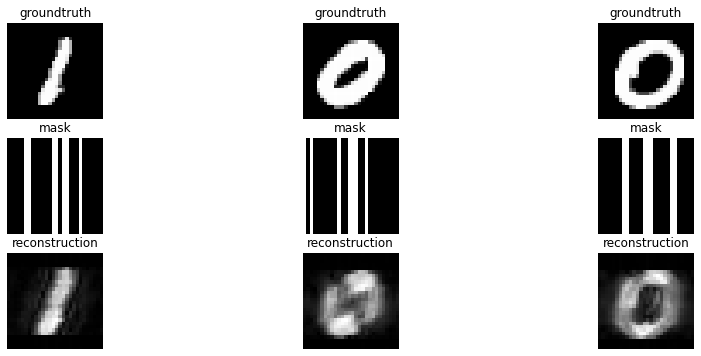

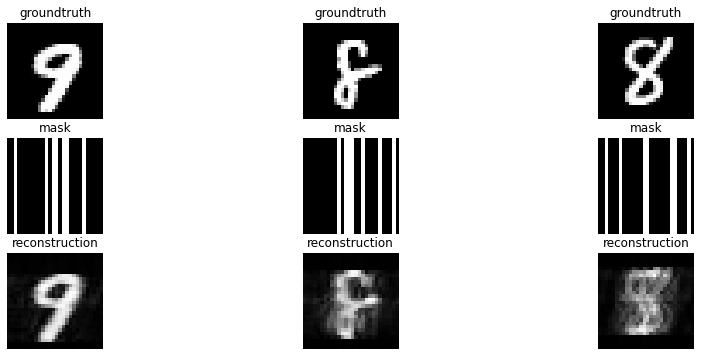

In [40]:

testing(configuration,show="non_sequential_plot")

Running on cpu
max on train data [223.76470686] 
 min on train data [0.]


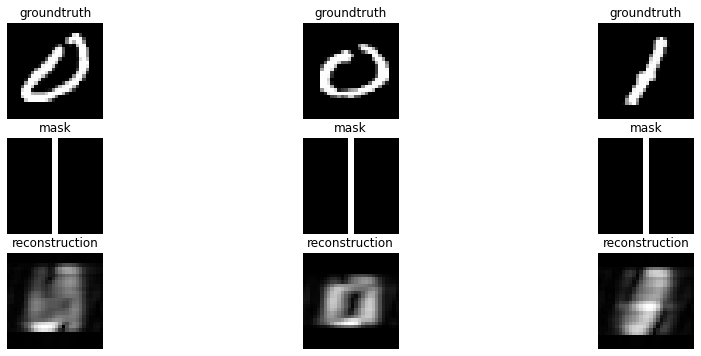

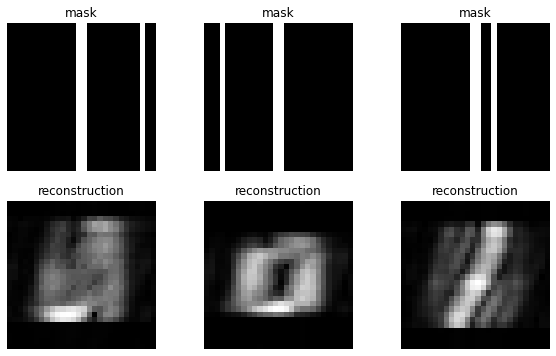

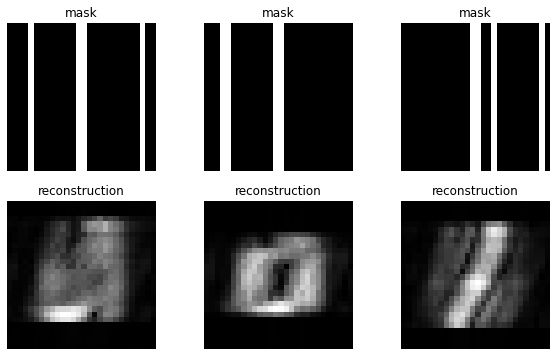

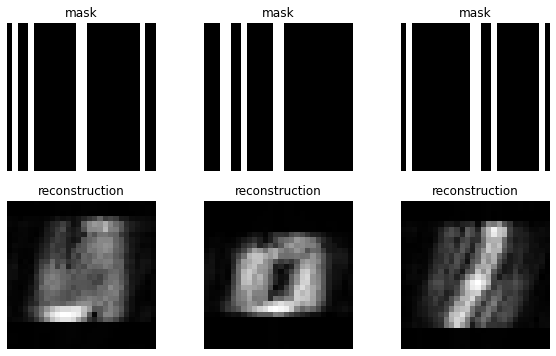

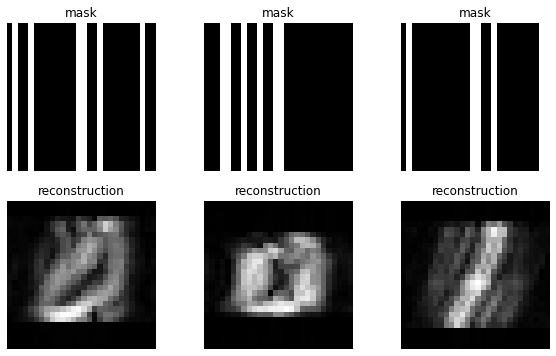

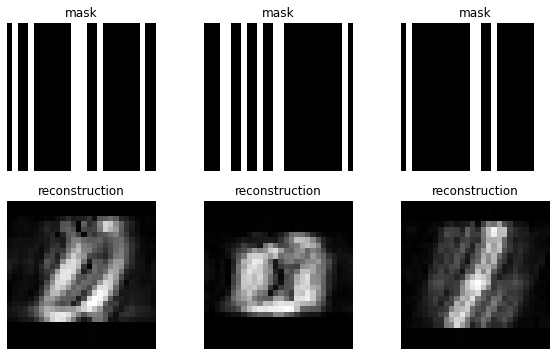

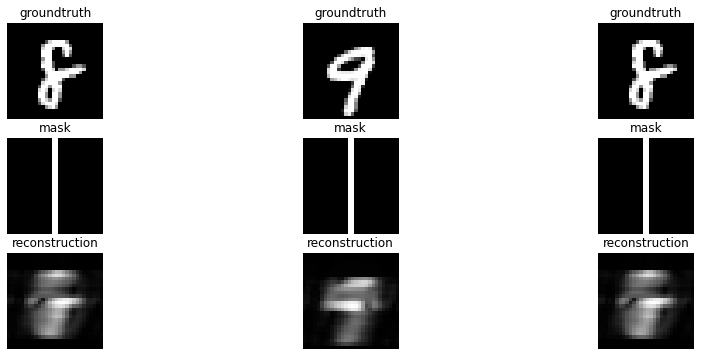

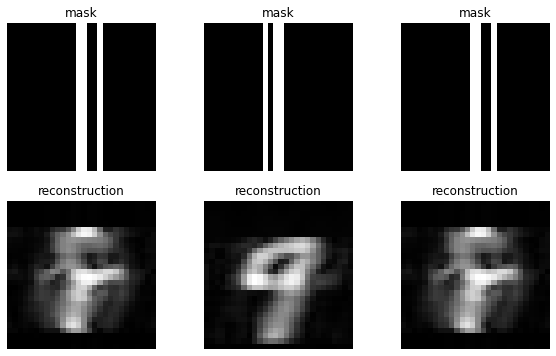

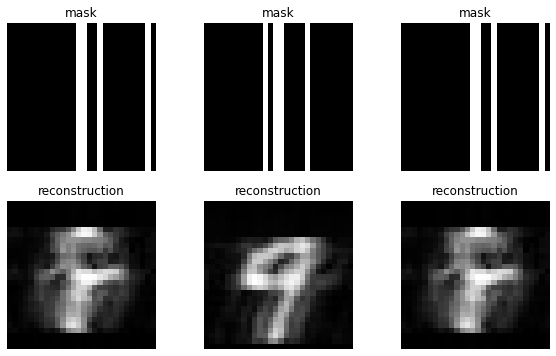

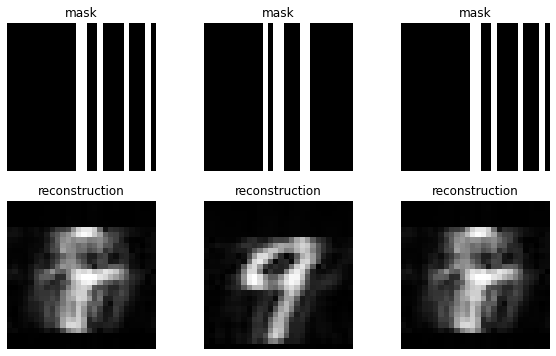

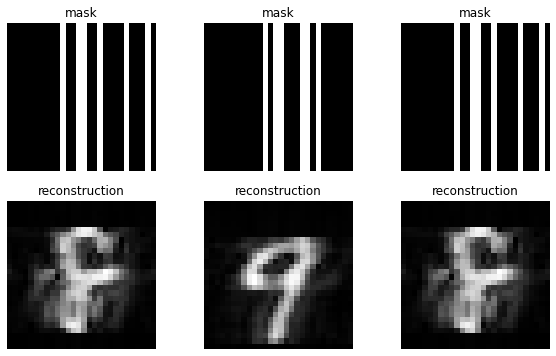

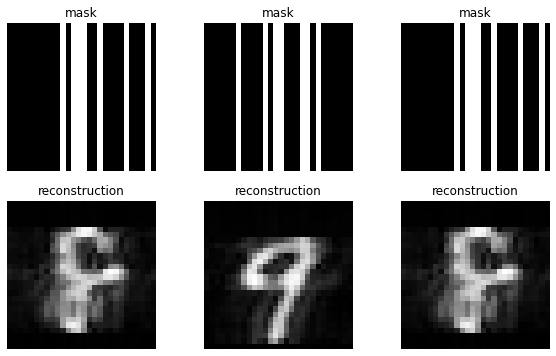

The test score for the model was -1.9783829306584917.


In [41]:
testing(configuration,show="sequential_plot")
## Mardi 22 Novembre 16h42